In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, neighbors, linear_model, neural_network
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.covariance import GraphicalLasso
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm_notebook
import warnings
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import manifold
from scipy.optimize import minimize  
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]
print(train.shape, test.shape)

(262144, 258) (131073, 257)


In [3]:
def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps

In [4]:
oof = np.zeros(len(train))
oof_qda = np.zeros(len(train))
oof_mlp = np.zeros(len(train))
oof_gmm = np.zeros(len(train))
oof_svc = np.zeros(len(train))
oof_nusvc = np.zeros(len(train))
oof_knn = np.zeros(len(train))
oof_lr = np.zeros(len(train))

preds = np.zeros(len(test))
preds_qda = np.zeros(len(test))
preds_mlp = np.zeros(len(test))
preds_gmm = np.zeros(len(test))
preds_svc = np.zeros(len(test))
preds_nusvc = np.zeros(len(test))
preds_knn = np.zeros(len(test))
preds_lr = np.zeros(len(test))

records = []
records_qda = []
records_mlp = []
records_gmm = []
records_svc = []
records_nusvc = []
records_knn = []
records_lr = []

In [5]:
# 512 models
for i in tqdm_notebook(range(512)):

    train2 = train[train['wheezy-copper-turtle-magic'] == i]
    test2 = test[test['wheezy-copper-turtle-magic'] == i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)

    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    pipe = Pipeline([('vt', VarianceThreshold(threshold=2)),
                     ('scaler', StandardScaler())])
    data2 = pipe.fit_transform(data[cols])
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]
    
    skf = StratifiedKFold(n_splits=11, random_state=2019,shuffle=True)
    ###################################################################################################
    #QDA:0.96491

    for train_index, test_index in skf.split(train2, train2['target']):
        qda = QuadraticDiscriminantAnalysis(0.1)
        qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_qda[idx1[test_index]] = qda.predict_proba(train3[test_index,:])[:,1]
        preds_qda[idx2] += qda.predict_proba(test3)[:,1] / skf.n_splits

    ###################################################################################################
    #MLP:0.914

#         mlp = neural_network.MLPClassifier(random_state=3,  activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(256, ))
#         mlp.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_mlp[idx1[test_index]] = mlp.predict_proba(train3[test_index,:])[:,1]
#         preds_mlp[idx2] += mlp.predict_proba(test3)[:,1] / skf.n_splits
        
    ###################################################################################################
    #GMM: 0.5 plain, 0.9675 with lasso init

        # MODEL AND PREDICT WITH QDA
        ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)
        
        gmm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
        gmm.fit(np.concatenate([train3,test3],axis = 0))
        oof_gmm[idx1[test_index]] = gmm.predict_proba(train3[test_index,:])[:,0]
        preds_gmm[idx2] += gmm.predict_proba(test3)[:,0] / skf.n_splits
    
    ###################################################################################################
    #SVC: 0.94262 ,0.87(3), 0.84(5)

#         # MODEL WITH SUPPORT VECTOR MACHINE
#         svc = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
#         svc.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_svc[idx1[test_index]] = svc.predict_proba(train3[test_index,:])[:,1]
#         preds_svc[idx2] += svc.predict_proba(test3)[:,1] / skf.n_splits
    
    ###################################################################################################
    #NuSVC: 0.95677, 0.93285(3), 0.93268(5)
        
#         nusvc = NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053)
#         nusvc.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_nusvc[idx1[test_index]] = nusvc.predict_proba(train3[test_index,:])[:,1]
#         preds_nusvc[idx2] += nusvc.predict_proba(test3)[:,1] / skf.n_splits
    
    ###################################################################################################
    #kNN: 0.91823 (16), 0.91892* (10), 0.91385(6), 0.91721(8)

#         knn = neighbors.KNeighborsClassifier(n_neighbors=10, p=2)
#         knn.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_knn[idx1[test_index]] = knn.predict_proba(train3[test_index,:])[:,1]
#         preds_knn[idx2] += knn.predict_proba(test3)[:,1] / skf.n_splits

    ###################################################################################################
    #LR:0.79655

#         lr = linear_model.LogisticRegression(solver='saga',penalty='l1',C=0.1)
#         lr.fit(train3[train_index,:],train2.loc[train_index]['target'])
#         oof_lr[idx1[test_index]] = lr.predict_proba(train3[test_index,:])[:,1]
#         preds_lr[idx2] += lr.predict_proba(test3)[:,1] / skf.n_splits

    ###################################################################################################
    qda_score = roc_auc_score(train['target'][idx1].values, oof_qda[idx1])
    gmm_score = roc_auc_score(train['target'][idx1].values, oof_gmm[idx1])
    combined_score = [qda_score, gmm_score]
    
    for train_index, test_index in skf.split(train2, train2['target']):
        if(np.argmax(combined_score) == 0):
            qda = QuadraticDiscriminantAnalysis(0.1)
            qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
            oof[idx1[test_index]] = qda.predict_proba(train3[test_index,:])[:,1]
            preds[idx2] += qda.predict_proba(test3)[:,1] / skf.n_splits
        else:
            ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)

            gmm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
            gmm.fit(np.concatenate([train3,test3],axis = 0))
            oof[idx1[test_index]] = gmm.predict_proba(train3[test_index,:])[:,0]
            preds[idx2] += gmm.predict_proba(test3)[:,0] / skf.n_splits
    
    
    records_qda.append(qda_score)
#     records_mlp.append(roc_auc_score(train['target'][idx1].values, oof_mlp[idx1]))
    records_gmm.append(gmm_score)
#     records_svc.append(roc_auc_score(train['target'][idx1].values, oof_svc[idx1]))
#     records_nusvc.append(roc_auc_score(train['target'][idx1].values, oof_nusvc[idx1]))
#     records_knn.append(roc_auc_score(train['target'][idx1].values, oof_knn[idx1]))
#     records_lr.append(roc_auc_score(train['target'][idx1].values, oof_lr[idx1]))
    
###################################################################################################


In [6]:
auc = roc_auc_score(train['target'], oof)
print(f'AUC: {auc:.5}')

AUC: 0.96765


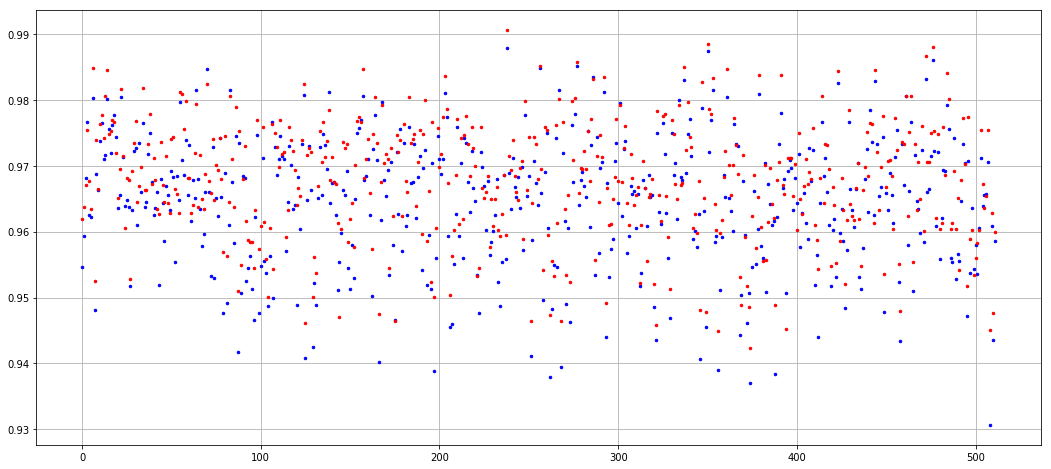

In [7]:
plt.figure(figsize=(18,8))
plt.plot(records_qda,'.b',markersize=5)
# plt.plot(records_mlp,'.k',markersize=5)
plt.plot(records_gmm,'.r',markersize=5)
# plt.plot(records_svc,'.g',markersize=5)
# plt.plot(records_nusvc,'.c',markersize=5)
# plt.plot(records_knn,'.m',markersize=5)
# plt.plot(records_lr,'.y',markersize=5)

plt.grid()

In [8]:
# print('qda', roc_auc_score(train['target'], oof_qda))
# print('mlp', roc_auc_score(train['target'], oof_mlp))
# print('gmm', roc_auc_score(train['target'], oof_gmm))
# print('svc', roc_auc_score(train['target'], oof_svc))
# print('nusvc', roc_auc_score(train['target'], oof_nusvc))
# print('knn', roc_auc_score(train['target'], oof_knn))
# print('lr', roc_auc_score(train['target'], oof_lr))

In [9]:
# oof_qda = oof_qda.reshape(-1, 1)
# preds_qda = preds_qda.reshape(-1, 1)

# oof_mlp = oof_mlp.reshape(-1, 1)
# preds_mlp = preds_mlp.reshape(-1, 1)

# oof_gmm = oof_gmm.reshape(-1, 1)
# preds_gmm = preds_gmm.reshape(-1, 1)

# oof_svc = oof_svc.reshape(-1, 1)
# preds_svc = preds_svc.reshape(-1, 1)

# oof_nusvc = oof_nusvc.reshape(-1, 1)
# preds_nusvc = preds_nusvc.reshape(-1, 1)

# oof_knn = oof_knn.reshape(-1, 1)
# preds_knn = preds_knn.reshape(-1, 1)

# oof_lr = oof_lr.reshape(-1, 1)
# preds_lr = preds_lr.reshape(-1, 1)

In [10]:
# tr = np.concatenate((oof_qda, oof_mlp, oof_gmm, oof_svc, oof_nusvc, oof_knn), axis=1)
# te = np.concatenate((preds_qda, preds_mlp, preds_gmm, preds_svc, preds_nusvc, preds_knn), axis=1)
# print(tr.shape, te.shape)

In [11]:
# # logistic regression stacking
# oof_stack_lr = np.zeros(len(train)) 
# preds_stack_lr = np.zeros(len(test))
# skf = StratifiedKFold(n_splits=5, random_state=42)

# for train_index, test_index in skf.split(tr, train['target']):
#     stack_lr = linear_model.LogisticRegression() # solver='liblinear',penalty='l1',C=0.1
#     stack_lr.fit(tr[train_index], train['target'][train_index])
#     oof_stack_lr[test_index] = stack_lr.predict_proba(tr[test_index,:])[:,1]
#     preds_stack_lr += stack_lr.predict_proba(te)[:,1] / skf.n_splits
    
# print('stack CV score =',round(roc_auc_score(train['target'],oof_stack_lr),5))

In [12]:
for itr in range(1):
    test['target'] = preds
    test.loc[test['target'] > 0.955, 'target'] = 1
    test.loc[test['target'] < 0.045, 'target'] = 0
    usefull_test = test[(test['target'] == 1) | (test['target'] == 0)]
    new_train = pd.concat([train, usefull_test]).reset_index(drop=True)
    print(usefull_test.shape[0], "Test Records added for iteration : ", itr)
    new_train.loc[oof > 0.995, 'target'] = 1
    new_train.loc[oof < 0.005, 'target'] = 0
    
    oof2 = np.zeros(len(train))
    oof_qda2 = np.zeros(len(train))
    oof_mlp2 = np.zeros(len(train))
    oof_gmm2 = np.zeros(len(train))
    oof_svc2 = np.zeros(len(train))
    oof_nusvc2 = np.zeros(len(train))
    oof_knn2 = np.zeros(len(train))
    oof_lr2 = np.zeros(len(train))
    
    preds = np.zeros(len(test))
    preds_qda = np.zeros(len(test))
    preds_mlp = np.zeros(len(test))
    preds_gmm = np.zeros(len(test))
    preds_svc = np.zeros(len(test))
    preds_nusvc = np.zeros(len(test))
    preds_knn = np.zeros(len(test))
    preds_lr = np.zeros(len(test))
    
    records_qda = []
    records_mlp = []
    records_gmm = []
    records_svc = []
    records_nusvc = []
    records_knn = []
    records_lr = []

    for i in tqdm_notebook(range(512)):

        train2 = new_train[new_train['wheezy-copper-turtle-magic']==i]
        test2 = test[test['wheezy-copper-turtle-magic']==i]
        idx1 = train[train['wheezy-copper-turtle-magic']==i].index
        idx2 = test2.index
        train2.reset_index(drop=True,inplace=True)

        data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
        pipe = Pipeline([('vt', VarianceThreshold(threshold=2)), ('scaler', StandardScaler())])
        data2 = pipe.fit_transform(data[cols])
        train3 = data2[:train2.shape[0]]
        test3 = data2[train2.shape[0]:]

        skf = StratifiedKFold(n_splits=11, random_state=42)    
        for train_index, test_index in skf.split(train2, train2['target']):
            oof_test_index = [t for t in test_index if t < len(idx1)]
        ###################################################################################################
        #QDA
        
            qda = QuadraticDiscriminantAnalysis(0.1)
            qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
            if len(oof_test_index) > 0:
                oof_qda2[idx1[oof_test_index]] = qda.predict_proba(train3[oof_test_index,:])[:,1]
            preds_qda[idx2] += qda.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #MLP

#             mlp = neural_network.MLPClassifier(random_state=3,  activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(256, ))
#             mlp.fit(train3[train_index,:],train2.loc[train_index]['target'])
#             if len(oof_test_index) > 0:
#                 oof_mlp2[idx1[oof_test_index]] = mlp.predict_proba(train3[oof_test_index,:])[:,1]
#             preds_mlp[idx2] += mlp.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #GMM

            # MODEL AND PREDICT WITH QDA
            ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)

            gmm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
            gmm.fit(np.concatenate([train3,test3],axis = 0))
            if len(oof_test_index) > 0:
                oof_gmm2[idx1[oof_test_index]] = gmm.predict_proba(train3[oof_test_index,:])[:,0]
            preds_gmm[idx2] += gmm.predict_proba(test3)[:,0] / skf.n_splits

        ###################################################################################################
        #SVC

#             # MODEL WITH SUPPORT VECTOR MACHINE
#             svc = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
#             svc.fit(train3[train_index,:],train2.loc[train_index]['target'])
#             if len(oof_test_index) > 0:
#                 oof_svc2[idx1[oof_test_index]] = svc.predict_proba(train3[oof_test_index,:])[:,1]
#             preds_svc[idx2] += svc.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #NuSVC

#             nusvc = NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053)
#             nusvc.fit(train3[train_index,:],train2.loc[train_index]['target'])
#             if len(oof_test_index) > 0:
#                 oof_nusvc2[idx1[oof_test_index]] = nusvc.predict_proba(train3[oof_test_index,:])[:,1]
#             preds_nusvc[idx2] += nusvc.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #kNN

#             knn = neighbors.KNeighborsClassifier(n_neighbors=10, p=2)
#             knn.fit(train3[train_index,:],train2.loc[train_index]['target'])
#             if len(oof_test_index) > 0:
#                 oof_knn2[idx1[oof_test_index]] = knn.predict_proba(train3[oof_test_index,:])[:,1]
#             preds_knn[idx2] += knn.predict_proba(test3)[:,1] / skf.n_splits

        ###################################################################################################
        #LR

#             lr = linear_model.LogisticRegression(solver='saga',penalty='l1',C=0.1)
#             lr.fit(train3[train_index,:],train2.loc[train_index]['target'])
#             if len(oof_test_index) > 0:
#                 oof_lr2[idx1[oof_test_index]] = lr.predict_proba(train3[oof_test_index,:])[:,1]
#             preds_lr[idx2] += lr.predict_proba(test3)[:,1] / skf.n_splits
        ###################################################################################################
        qda_score = roc_auc_score(train['target'][idx1].values, oof_qda2[idx1])
        gmm_score = roc_auc_score(train['target'][idx1].values, oof_gmm2[idx1])
        combined_score = [qda_score, gmm_score]

        for train_index, test_index in skf.split(train2, train2['target']):
            oof_test_index = [t for t in test_index if t < len(idx1)]
            
            if(np.argmax(combined_score) == 0):
                qda = QuadraticDiscriminantAnalysis(0.1)
                qda.fit(train3[train_index,:],train2.loc[train_index]['target'])
                if len(oof_test_index) > 0:
                    oof2[idx1[oof_test_index]] = qda.predict_proba(train3[oof_test_index,:])[:,1]
                preds[idx2] += qda.predict_proba(test3)[:,1] / skf.n_splits
            else:
                ms, ps = get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)

                gmm = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps)
                gmm.fit(np.concatenate([train3,test3],axis = 0))
                if len(oof_test_index) > 0:
                    oof2[idx1[oof_test_index]] = gmm.predict_proba(train3[oof_test_index,:])[:,0]
                preds[idx2] += gmm.predict_proba(test3)[:,0] / skf.n_splits
                
                
        records_qda.append(qda_score)
        records_gmm.append(gmm_score)
    
#     print('qda', roc_auc_score(train['target'], oof_qda2))
#     print('mlp', roc_auc_score(train['target'], oof_mlp2))
#     print('gmm', roc_auc_score(train['target'], oof_gmm2))
#     print('svc', roc_auc_score(train['target'], oof_svc2))
#     print('nusvc', roc_auc_score(train['target'], oof_nusvc2))
#     print('knn', roc_auc_score(train['target'], oof_knn2))
#     print('lr', roc_auc_score(train['target'], oof_lr2))
    
#     oof_qda2 = oof_qda2.reshape(-1, 1)
#     preds_qda = preds_qda.reshape(-1, 1)

#     oof_mlp2 = oof_mlp2.reshape(-1, 1)
#     preds_mlp = preds_mlp.reshape(-1, 1)

#     oof_gmm2 = oof_gmm2.reshape(-1, 1)
#     preds_gmm = preds_gmm.reshape(-1, 1)

#     oof_svc2 = oof_svc2.reshape(-1, 1)
#     preds_svc = preds_svc.reshape(-1, 1)

#     oof_nusvc2 = oof_nusvc2.reshape(-1, 1)
#     preds_nusvc = preds_nusvc.reshape(-1, 1)

#     oof_knn2 = oof_knn2.reshape(-1, 1)
#     preds_knn = preds_knn.reshape(-1, 1)

#     oof_lr2 = oof_lr2.reshape(-1, 1)
#     preds_lr = preds_lr.reshape(-1, 1)
    
#     tr = np.concatenate((oof_qda2, oof_mlp2, oof_gmm2, oof_svc2, oof_nusvc2, oof_knn2), axis=1)
#     te = np.concatenate((preds_qda, preds_mlp, preds_gmm, preds_svc, preds_nusvc, preds_knn), axis=1)
#     print(tr.shape, te.shape)
    
#     # logistic regression stacking
#     oof_stack_lr = np.zeros(len(train)) 
#     preds_stack_lr = np.zeros(len(test))
#     skf = StratifiedKFold(n_splits=5, random_state=42)

#     for train_index, test_index in skf.split(tr, train['target']):
#         stack_lr = linear_model.LogisticRegression() # solver='liblinear',penalty='l1',C=0.1
#         stack_lr.fit(tr[train_index], train['target'][train_index])
#         oof_stack_lr[test_index] = stack_lr.predict_proba(tr[test_index,:])[:,1]
#         preds_stack_lr += stack_lr.predict_proba(te)[:,1] / skf.n_splits

#     print('stack CV score =',round(roc_auc_score(train['target'],oof_stack_lr),5))

122221 Test Records added for iteration :  0


In [13]:
auc = roc_auc_score(train['target'], oof2)
print(f'AUC: {auc:.5}')

AUC: 0.97001


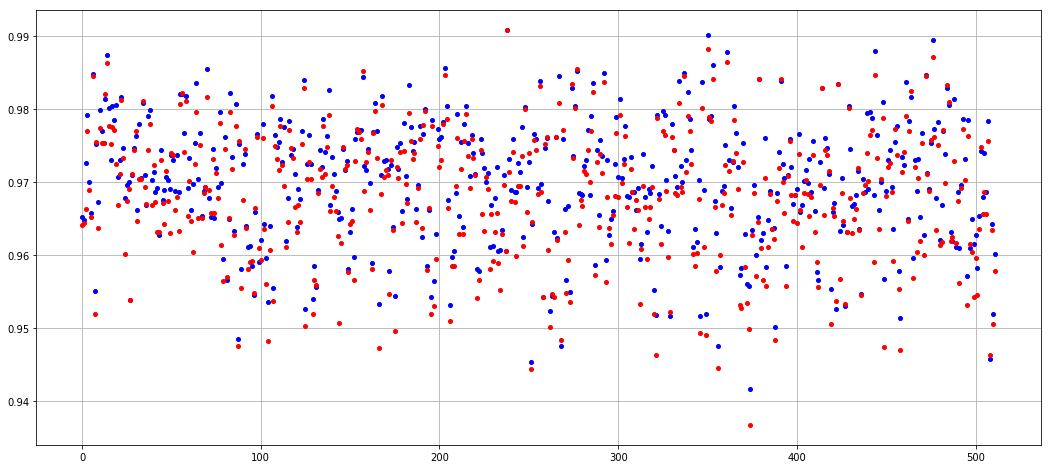

In [18]:
plt.figure(figsize=(18,8))
plt.plot(records_qda,'.b',markersize=8)
# plt.plot(records_mlp,'.k',markersize=5)
plt.plot(records_gmm,'.r',markersize=8)
# plt.plot(records_svc,'.g',markersize=5)
# plt.plot(records_nusvc,'.c',markersize=5)
# plt.plot(records_knn,'.m',markersize=5)
# plt.plot(records_lr,'.y',markersize=5)

plt.grid()

In [15]:
# plt.hist(preds,bins=100)
# plt.title('Final Test.csv predictions')
# plt.show()

sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)

In [30]:
records_qda.sort()

In [35]:
np.argsort(records_gmm)

array([374, 251, 356, 321, 508, 458, 166, 449,  87, 104, 268, 388, 349,
       346, 175, 373, 262, 125, 419, 510, 144, 206, 320,   7, 195, 129,
       329, 369, 197, 495, 368, 312, 427, 372, 273, 107, 422,  27, 221,
       264, 499, 258, 436, 501, 172, 263, 271,  96, 234, 457,  89, 412,
       394, 383, 131, 103, 491, 293,  79, 152, 381, 222, 130, 424, 465,
        81, 377, 287, 149, 355, 511, 193, 162, 228,  93, 371, 343, 208,
       207, 233, 411,  94, 443, 454, 230,  95, 100, 272, 198, 316, 500,
       328, 243, 471, 357, 342,  24, 344,  62, 498, 467, 237, 261, 105,
       313, 380,  99, 403, 114, 384, 348, 247, 480,  78, 497, 296, 324,
       145, 489, 306, 481, 486, 469, 266, 387, 487, 143, 375,  85, 235,
       211, 213, 431,  49, 270, 231, 410,  43, 428, 120,  42,  54, 225,
       509, 435, 478, 174, 309, 102, 446, 386, 502,  92, 295, 190,   9,
       289, 278,   0,  46, 150, 400,   1, 179, 115, 122, 378, 252, 187,
       398,  31, 151,  61, 462, 426, 432, 317,  82,  65,  67,   

In [24]:
train.shape


(262144, 258)

In [52]:
records_gmm[59]

0.9654145035426258